# Text Analysis With Python 

This workshop covers a number of text analysis techniques using Python. It assumes you You are welcome to follow along in the IDE of your choice, but the instructors will be using Jupyter Lab.

## Be sure you have the following packages installed
- **pandas**
- **sklearn**
- **seaborn**

Additionally, we will be using **os and re**

## Python Packages often used for Text Analysis - Rolando
- Directly related to Text Analysis
    - NLTK
    - spaCy
    - Textblob
    - Gensim
    - Transformers

- Useful tools for text analysis
    - Pandas
    - Scikit-Learn
    - Matplotlib


## Mini-project 1: Word Frequencies (1:05) - Rolando

#### Data: [Jane Eyre - Charlotte Brontë](https://www.gutenberg.org/files/1260/1260-h/1260-h.htm)
#### Tools: NLTK, Scitkit-learn, Pandas
#### Method: Simple N-grams (Document vs Chapters), Maybe TF-IDF, 

##### 1. Load in text

We're going to use `urlretrieve` to save a local copy of the Jane Eyre text file.

In [1]:
from urllib.request import urlretrieve

urlretrieve('https://www.gutenberg.org/cache/epub/1260/pg1260.txt', 'jane_eyre.txt')

doc = open('jane_eyre.txt', 'r').readlines()


We can see that the text file is read line by line, so we're going to have to split the list into sections.

In [2]:
doc[:20]

['\ufeffThe Project Gutenberg eBook of Jane Eyre: An Autobiography\n',
 '    \n',
 'This ebook is for the use of anyone anywhere in the United States and\n',
 'most other parts of the world at no cost and with almost no restrictions\n',
 'whatsoever. You may copy it, give it away or re-use it under the terms\n',
 'of the Project Gutenberg License included with this ebook or online\n',
 'at www.gutenberg.org. If you are not located in the United States,\n',
 'you will have to check the laws of the country where you are located\n',
 'before using this eBook.\n',
 '\n',
 'Title: Jane Eyre: An Autobiography\n',
 '\n',
 'Author: Charlotte Brontë\n',
 '\n',
 'Illustrator: F. H. Townsend\n',
 '\n',
 'Release date: March 1, 1998 [eBook #1260]\n',
 '                Most recently updated: May 2, 2023\n',
 '\n',
 'Language: English\n']

We're going to focus on the text from the preface and chapters from the book. First, we're obtaining the indexes of of where these section titles appear in the list of lines from the text.

In [3]:
chapter_idx = []

for idx, line in enumerate(doc):
    if 'CHAPTER' in line:
        chapter_idx.append((idx, line.strip()))
        
print(chapter_idx)

[(172, 'CHAPTER I'), (401, 'CHAPTER II'), (690, 'CHAPTER III'), (1088, 'CHAPTER IV'), (1737, 'CHAPTER V'), (2313, 'CHAPTER VI'), (2648, 'CHAPTER VII'), (3023, 'CHAPTER VIII'), (3354, 'CHAPTER IX'), (3707, 'CHAPTER X'), (4182, 'CHAPTER XI'), (4877, 'CHAPTER XII'), (5322, 'CHAPTER XIII'), (5854, 'CHAPTER XIV'), (6409, 'CHAPTER XV'), (6926, 'CHAPTER XVI'), (7348, 'CHAPTER XVII'), (8228, 'CHAPTER XVIII'), (8867, 'CHAPTER XIX'), (9387, 'CHAPTER XX'), (10110, 'CHAPTER XXI'), (11090, 'CHAPTER XXII'), (11373, 'CHAPTER XXIII'), (11858, 'CHAPTER XXIV'), (12712, 'CHAPTER XXV'), (13267, 'CHAPTER XXVI'), (13748, 'CHAPTER XXVII'), (14855, 'CHAPTER XXVIII'), (15614, 'CHAPTER XXIX'), (16161, 'CHAPTER XXX'), (16577, 'CHAPTER XXXI'), (16906, 'CHAPTER XXXII'), (17386, 'CHAPTER XXXIII'), (17990, 'CHAPTER XXXIV'), (18961, 'CHAPTER XXXV'), (19442, 'CHAPTER XXXVI'), (19872, 'CHAPTER XXXVII'), (20851, 'CHAPTER XXXVIII—CONCLUSION')]


Now, we're going to push a list of lines that pertain to the certain section into a new list.

In [4]:
chapter_texts = []

for idx, ch in enumerate(chapter_idx):
    # Skipping the first line of the section to cut out the chapter title
    start_line = ch[0]+1
    
    # Setting the end line of the chapter based on when the following chapter starts
    try:
        end_line = chapter_idx[idx+1][0]
    except:
        end_line = len(doc)
        
    # Adds text to the list of chapter texts
    chapter_texts.append(doc[start_line:end_line])    

In [5]:
# the first ten lines from the preface
chapter_texts[0][:10]

['\n',
 '\n',
 'There was no possibility of taking a walk that day. We had been\n',
 'wandering, indeed, in the leafless shrubbery an hour in the morning;\n',
 'but since dinner (Mrs. Reed, when there was no company, dined early)\n',
 'the cold winter wind had brought with it clouds so sombre, and a rain\n',
 'so penetrating, that further outdoor exercise was now out of the\n',
 'question.\n',
 '\n',
 'I was glad of it: I never liked long walks, especially on chilly\n']

##### 2. Processing the text

Most text analysis projects require a number of steps to **preprocess** the text. Usually, this involves removing undesired characters such as punctuation and line breaks. Below, we use [**regular expressions**](https://docs.python.org/3/library/re.html) to achieve this task. 

We have the text we want, but now we have to process the text we're working with. This involves removing line breaks (`\n`) and punctuation. In other cases, this might involve stemming or lemmatizing words. 

In [6]:
import re

# join the lines together first with nested list comprehensions while removing items that are only line breaks
joined_chs = [''.join([line for line in ch if line != '\n']) for ch in chapter_texts]

print(joined_chs)

['There was no possibility of taking a walk that day. We had been\nwandering, indeed, in the leafless shrubbery an hour in the morning;\nbut since dinner (Mrs. Reed, when there was no company, dined early)\nthe cold winter wind had brought with it clouds so sombre, and a rain\nso penetrating, that further outdoor exercise was now out of the\nquestion.\nI was glad of it: I never liked long walks, especially on chilly\nafternoons: dreadful to me was the coming home in the raw twilight,\nwith nipped fingers and toes, and a heart saddened by the chidings of\nBessie, the nurse, and humbled by the consciousness of my physical\ninferiority to Eliza, John, and Georgiana Reed.\nThe said Eliza, John, and Georgiana were now clustered round their mama\nin the drawing-room: she lay reclined on a sofa by the fireside, and\nwith her darlings about her (for the time neither quarrelling nor\ncrying) looked perfectly happy. Me, she had dispensed from joining the\ngroup; saying, “She regretted to be unde

In [7]:
# replace remaining break lines with spaces
no_bl_chs = [re.sub(r'\n', ' ', ch) for ch in joined_chs]

print(no_bl_chs)

['There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further outdoor exercise was now out of the question. I was glad of it: I never liked long walks, especially on chilly afternoons: dreadful to me was the coming home in the raw twilight, with nipped fingers and toes, and a heart saddened by the chidings of Bessie, the nurse, and humbled by the consciousness of my physical inferiority to Eliza, John, and Georgiana Reed. The said Eliza, John, and Georgiana were now clustered round their mama in the drawing-room: she lay reclined on a sofa by the fireside, and with her darlings about her (for the time neither quarrelling nor crying) looked perfectly happy. Me, she had dispensed from joining the group; saying, “She regretted to be under the necessity

Since we're going going to be using sentences are our documenet length instead of chapters, we need to remove the periods after "Mr" and "Mrs" to prevent sentences being split at the wrong place (i.e. `"Mr. Rochester goes..."` => `["Mr", "Rochester goes..."]`)

In [8]:
# remove punctuation except periods
no_punct_chs = [re.sub(r'[:;,_“”\']', '', ch) for ch in no_bl_chs]

# remove periods after Mr and Mrs
no_punct_chs=[re.sub(r'(?<=Mr)\.', '', ch) for ch in no_punct_chs]
no_punct_chs=[re.sub(r'(?<=Mrs)\.', '', ch) for ch in no_punct_chs]

print(no_punct_chs)

['There was no possibility of taking a walk that day. We had been wandering indeed in the leafless shrubbery an hour in the morning but since dinner (Mrs Reed when there was no company dined early) the cold winter wind had brought with it clouds so sombre and a rain so penetrating that further outdoor exercise was now out of the question. I was glad of it I never liked long walks especially on chilly afternoons dreadful to me was the coming home in the raw twilight with nipped fingers and toes and a heart saddened by the chidings of Bessie the nurse and humbled by the consciousness of my physical inferiority to Eliza John and Georgiana Reed. The said Eliza John and Georgiana were now clustered round their mama in the drawing-room she lay reclined on a sofa by the fireside and with her darlings about her (for the time neither quarrelling nor crying) looked perfectly happy. Me she had dispensed from joining the group saying She regretted to be under the necessity of keeping me at a dista

Now, we will tokenize the chapters into sentence-level tokens and reduce our list into a one-dimensional list.

In [9]:
# divide chapters into sentences
from nltk.tokenize import PunktSentenceTokenizer
from functools import reduce
# nltk.download('punkt)

punkt = PunktSentenceTokenizer()

# this operation produces a list of lists of sentences (i.e. [["sentence 1", "sentence 2"], ["sentence 3", "sentence 4"]])
sents = [punkt.tokenize(ch) for ch in no_punct_chs]

# reduce the two-dimensional list into a one-dimensional list
sent_tokens = reduce(lambda x,y :x+y ,sents)

#### 3. Vectorize Text
Using Scikit-learn's [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [TFIDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Scikit-learn has a built-in tool `CountVectorizer` which allows us to pass in a corpus of text and it will return vectors informing us how many times a word showed up in a document (sentence) for ebery word that appears in the corpus. 

We didn't remove stop words earlier in the preprocessing step because `CountVectorizer` allows us to indicate stop words when initializing it. By default, it sets all words to lowercase, but we have set the parameter here to make it explicit. Additionally, we can set what ngrams we're interested in (unigrams, bigrams, trigrams, etc).

In [10]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = list(stopwords.words('english'))

# demonstrating some of the parameters within Count Vectorizer
vc = CountVectorizer(lowercase=True, 
                     stop_words=stopwords,
                     ngram_range=(2,2),
                    
                     min_df=0.001)

vectors = vc.fit_transform(sent_tokens)


Below, we can see the output of the CountVectorizer and the frequency of different words used in the text.

In [11]:
print(vc.vocabulary_)

{'mrs reed': 54, 'drawing room': 10, 'right hand': 64, 'cannot tell': 2, 'john reed': 27, 'would soon': 85, 'never thought': 57, 'red room': 63, 'would say': 84, 'miss eyre': 35, 'said bessie': 65, 'ere long': 15, 'great deal': 21, 'let go': 29, 'would come': 79, 'jane eyre': 26, 'miss jane': 37, 'five minutes': 17, 'mr lloyd': 45, 'next day': 58, 'would like': 81, 'shall go': 70, 'came back': 1, 'half hour': 24, 'one day': 60, 'long time': 33, 'long way': 34, 'yes sir': 87, 'would rather': 83, 'shook head': 71, 'could see': 6, 'young ladies': 88, 'said mr': 66, 'first time': 16, 'said mrs': 67, 'good night': 19, 'ten minutes': 72, 'little girl': 32, 'mr brocklehurst': 43, 'miss temple': 41, 'come see': 4, 'well enough': 78, 'last night': 28, 'miss miller': 38, 'one side': 61, 'miss scatcherd': 40, 'could bear': 5, 'helen burns': 25, 'would never': 82, 'said nothing': 68, 'would take': 86, 'could tell': 7, 'let us': 30, 'would give': 80, 'two hours': 76, 'eight years': 12, 'mrs fairfax

We can create a dataframe of vectors. The columns refer to the bigrams extracted from the corpus. Each row's index refers to a document (sentence) in the corpus. The values in each cell is how many times that bigram appeared in the sentence. 

In [12]:
cols = vc.get_feature_names_out()
word_vect_df = pd.DataFrame(data=vectors.toarray(), columns=cols)
word_vect_df.sample(10)

,archive foundation,came back,cannot tell,colonel dent,come see,could bear,could see,could tell,diana mary,dining room,...,would come,would give,would like,would never,would rather,would say,would soon,would take,yes sir,young ladies
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3893,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see the top 20 bigrams with the higestest frequencies

In [13]:
word_vect_df.sum(axis=0).sort_values(ascending=False).head(20)

mr rochester         332
mrs fairfax          121
project gutenberg     85
mrs reed              81
miss temple           63
miss ingram           58
mr brocklehurst       45
miss eyre             45
jane eyre             38
yes sir               35
thornfield hall       33
mr rivers             33
diana mary            31
drawing room          26
could see             25
said mr               24
last night            23
miss miller           23
mr mason              23
mr st                 23
dtype: int64

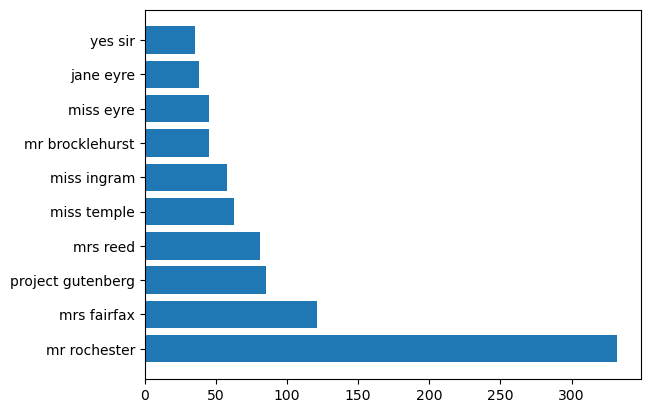

In [14]:
import matplotlib.pyplot as plt

word_counts = word_vect_df.sum(axis=0).sort_values(ascending=False)
plt.barh(y=word_counts.index[:10], width=word_counts[:10])
plt.show()

Many of the words with the highest frequencies are part of characters' names, which we expect to show up a lot more. These don't necessarily give us a lot of information however, but we can check how 'informative' these terms are by finding their TFIDF scores. 

In [15]:
tc = TfidfVectorizer(lowercase=True, 
                     stop_words=stopwords,
                     ngram_range=(2,2),
                     max_df=0.9,
                     min_df=0.1)

tc_vectors = tc.fit_transform(no_punct_chs)


tfidf_vect_df = pd.DataFrame(data=tc_vectors.toarray(), columns=tc.get_feature_names_out())
tfidf_vect_df.sample(10)

,actually took,adèle came,almost like,already made,another time,answer question,answered yes,anything else,arm chair,arms round,...,years since,yes right,yes said,yes sir,yes yes,yet could,yet know,yet said,young ladies,young lady
15,0.0,0.059953,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.056374,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046346,0.000000
30,0.0,0.000000,0.109129,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.04928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.056861,0.0,0.000000,...,0.000000,0.00000,0.000000,0.072814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.081215,0.000000,0.126842,0.000000,0.000000,0.000000,0.000000
8,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.086325,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.0,0.000000,0.000000,0.044654,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.083976,0.000000,0.000000,0.044654,0.000000,0.000000,0.034519,0.036060
20,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.051704,0.00000,0.000000,0.140828,0.000000,0.000000,0.054986,0.054986,0.212535,0.000000
34,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35,0.0,0.000000,0.092450,0.000000,0.09245,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.078223,0.092450,0.000000,0.000000,0.000000,0.074658


In [16]:
tfidf_vect_df.mean(axis=0).sort_values(ascending=False).head(20)

mr rochester       0.254307
st john            0.148947
mrs fairfax        0.116914
mrs reed           0.083966
miss temple        0.077260
miss ingram        0.062901
miss eyre          0.056189
mr rivers          0.054495
mr brocklehurst    0.046019
diana mary         0.041832
yes sir            0.041395
thornfield hall    0.040288
jane eyre          0.039254
mr st              0.036489
miss scatcherd     0.034366
helen burns        0.033323
mr mason           0.033289
last night         0.030306
miss jane          0.029874
could see          0.029271
dtype: float64

#### Term Co-Occurance

We may be interested in see how words co-occur with others words. In this case, we will use unigrams instead of bigrams. 

In [17]:
cvc = CountVectorizer(lowercase=True, 
                     stop_words=stopwords,
                     ngram_range=(1,1),
                    
                     min_df=0.001)

co_vectors = cvc.fit_transform(sent_tokens)

# matrix manipulation 
co_matrix = (co_vectors.T * co_vectors)

# setting the diagonals to 0 since it will always be 1 when we're comparing the same words
co_matrix.setdiag(0)

Below is a dataframe that shows how many times one word (column) co-occurs within the same sentence as another word (row)

In [18]:
co_cols = cvc.get_feature_names_out()
co_df = pd.DataFrame(data=co_matrix.toarray(), columns=co_cols, index=co_cols)
co_df.sample(10)

,abbot,able,absence,absolutely,absorbed,accent,accept,access,accompany,account,...,year,years,yes,yesterday,yet,yield,yonder,young,younger,youth
pounds,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,0
hours,0,1,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,2,0,0,0
remained,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
table,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,3,0,1,1,0,0
gates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
spring,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leaning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
band,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kiss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
life,0,0,0,2,0,0,0,0,0,0,...,0,6,3,1,13,1,1,3,0,1


We may be interested in seeing what are the most common words that show up in the same sentence that 'rochester' (referring to Mr. Rochester) appears. 

In [19]:
co_df['rochester'].sort_values(ascending=False).head(20)

mr         362
said        50
would       39
see         33
mrs         31
fairfax     28
could       25
heard       24
never       22
go          18
like        18
room        17
hand        17
one         16
well        16
yes         15
eyes        15
knew        15
adèle       15
long        14
Name: rochester, dtype: int64

## Mini-project 2: Classification (1:15) - Lorin

#### Data: [On the Books Laws](https://cdr.lib.unc.edu/concern/data_sets/v405sk89q?locale=en)
#### Tools: Scitkit-learn, Pandas, 
#### Methods: Supervised (Jim Crow vs. Non-Jim Crow) vs Unsupervised (Topic-modeling)
#### Helpful: [Comparing classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)


### Create Testing & Training Sets

Bring in labeled training set

In [20]:
import pandas as pd

df = pd.read_csv("datasets/otb_training_set.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      1785 non-null   object
 1   source                  1785 non-null   object
 2   jim_crow                1785 non-null   int64 
 3   chapter_num             1785 non-null   int64 
 4   section_num             1785 non-null   int64 
 5   chapter_text            1785 non-null   object
 6   section_text            1785 non-null   object
 7   year                    1785 non-null   int64 
 8   type_private laws       1785 non-null   int64 
 9   type_public laws        1785 non-null   int64 
 10  type_public local laws  1785 non-null   int64 
 11  type_session laws       1785 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 167.5+ KB


Includes 512 examples of Jim Crow laws and 1273 non Jim Crow laws.

In [21]:
df.jim_crow.value_counts()

0    1273
1     512
Name: jim_crow, dtype: int64

Laws were labeled as Jim Crow or Not Jim Crow according to scholarly works (Pauli Murray, Richard Paschal) and experts at UNC (William Sturkey, among others)

In [22]:
df.source.value_counts()

project experts    1673
paschal              74
murray               38
Name: source, dtype: int64

We need to pick a target for our classification, aka the "output".

In [23]:
target = df["jim_crow"]

What features do we want to train the models on? They will be our "inputs".

In [24]:
features = df.loc[:, "section_text" : "type_session laws"]
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   section_text            1785 non-null   object
 1   year                    1785 non-null   int64 
 2   type_private laws       1785 non-null   int64 
 3   type_public laws        1785 non-null   int64 
 4   type_public local laws  1785 non-null   int64 
 5   type_session laws       1785 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 83.8+ KB


Use train-test-split to separate data into training and testing sets. 80% will be training, 20% will be testing - set by test_size = 0.2.  Data is chosen for the different sets at random, so random_state allows us all to get the same results. X_train and X_test include the inputs. y_train and y_test include the output.

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 25)

### Vectorize the text

As above, we need to find word frequencies

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(decode_error = "ignore", min_df = 2, max_df = 1000)

In this case, we've chosen to ingore errors when it comes to characters with the wrong encoding. Additionally, we are not including any words that are too rarely used in the text (less than two times) or too often used (more than 1000 times).

Below, the vectorization is applied.

In [27]:
X_train = vec.fit_transform(X_train.section_text)
X_test = vec.transform(X_test.section_text)

Now we need to decide on a machine learning classification model. In this case, we are using multinomial Naive Bayes which comes with sklearn.

In [28]:
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB()
nb.fit(X_train, y_train)



MultinomialNB()

Now that we've trained the model on our data, let's use it on the testing set and see how well it did.

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

preds = nb.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.86      0.92       265
           1       0.70      0.93      0.80        92

    accuracy                           0.88       357
   macro avg       0.84      0.90      0.86       357
weighted avg       0.91      0.88      0.89       357



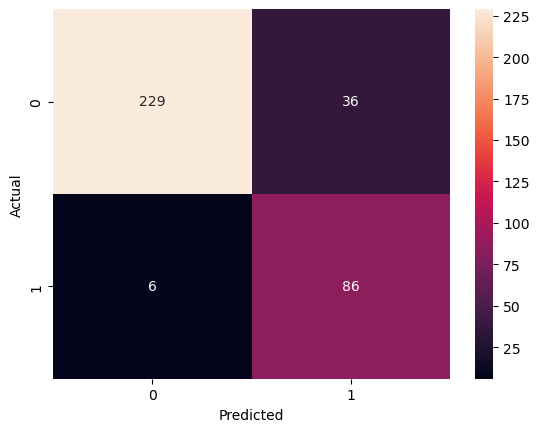

In [30]:
import seaborn as sns

# count the number of labels
labels = np.unique(preds)

data = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f')

We remove stopwords, tokenize the text, lemmatize

## Mini-project 3: Sentiment Analysis (1:35) - Rolando

#### Data: [Chaptgpt Sentiment Analysis](https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis)
#### Tools: Textblob, NLTK
#### Methods: Dictionary (+ rule-based)

We will be using a [dataset of tweets about ChatGPT from Kaggle](https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis/data?select=file.csv) for this example. 

#### 1. Importing ChatGPT twitter data

In [31]:
df = pd.read_csv('./datasets/chatgpt_sentiment.csv', encoding='utf-8')


In [32]:
df.shape

(219294, 3)

In [33]:
df.sample(10)

,Unnamed: 0,tweets,labels
165515,165515,"ChatGPT Is A Threat, But Google Is Still A Buy...",bad
159474,159474,Would be nice if twitter for their newsletter ...,good
161899,161899,How to use ChatGPT in Python using pyChatGPT h...,bad
7657,7657,So far one of my favourite use of ChatGPT has ...,neutral
91003,91003,Strange #chatGPT \n\nWonder why it jumped to d...,bad
204430,204430,After Google spam update can we buy gusset pos...,bad
165739,165739,"To those in tech, ChatGPT is basically HAL 900...",bad
134104,134104,I think ChatGPT will be offended by this comme...,bad
5800,5800,#TheVerge: OpenAI’s new chatbot can explain co...,neutral
106564,106564,#ChatGPT on \n\nhttps://t.co/W4Wgqmmvga\n\n#S...,good


In [34]:
df_sample = df.copy().sample(50000)

#### 1. Simple Sentiment Analysis using Textblob

[`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) is a Python library that allows for easy access to text analysis methods such as parts-of-speech tagging, tokenization, term frequencies, sentiment analysis, and more. 

In [35]:
#! pip install textblob
from textblob import TextBlob

# simple example of TextBlob
example_tweet = TextBlob(df.tweets[22747])

example_tweet.sentiment_assessments

Sentiment(polarity=0.3, subjectivity=0.7, assessments=[(['greatest'], 1.0, 1.0, None), (['game'], -0.4, 0.4, None)])

`TextBlob.sentiment_assessments` returns the overall sentiment polarity and subjectivity of the sentence alongside the polarity and subjectivity of individual terms that make up the composite score. Polarity scores range from -1 (most negative) to 1 (most positive); subjectivity scores range from 0 (most objective) to 1 (most subjective). Below we can see the text that of the tweet that had a polarity score of 0.3 and a subjectivity score of 0.7.

In [36]:
df.tweets[22747]

'ChatGPT is the greatest video game of all time'

In [37]:
# method to return the sentiment scores for a given text
def textblob_scores(text):
    try:
        return TextBlob(text).sentiment
    except:
        dict() # returns an empty dictionary if there is an issue with the text

In [38]:
# find the sentiment polarity/subjectivity scores for all the tweets in our sample dataframe
tweets_txtblob = df_sample.tweets.apply(textblob_scores).apply(pd.Series)

# creates new columns in with those scores 
tweet_scores = pd.concat([df_sample, tweets_txtblob], axis =1)

In [39]:
# renames columns so we can make sense of them 
tweet_scores.rename(columns={0: 'textblob_polarity', 1: 'textblob_subjectivity'}, inplace=True)

tweet_scores.sample(5)

,Unnamed: 0,tweets,labels,textblob_polarity,textblob_subjectivity
63656,63656,"With the introduction of GPT4 and ChatGPT, we ...",neutral,0.000000,0.100000
25642,25642,So #ChatGPT is multilingual &amp; you can ask ...,bad,0.000000,0.250000
21965,21965,A billion people asking ChatGPT to do this and...,bad,0.000000,0.000000
56685,56685,I've finally managed to set up redirects from ...,neutral,0.059091,0.438636
175006,175006,Writing Power BI Measures with ChatGPT is savi...,bad,0.200000,0.200000


#### 2. Sentiment Analysis using NLTK

[`NLTK`](https://www.nltk.org/) has has a  `SentimentintensityAnalyzer` module for sentiment analysis which uses the [`Vader model`](https://ojs.aaai.org/index.php/ICWSM/article/view/14550). Vader uses both a sentiment valence lexicon alongside rule-based modifiers to determine sentiment scores. `Valence` refers to the direction and intensity of a score ("worst" vs "bad" vs "best"). `Lexicon` refers to list of words that are mapped to a particular sentiment or emotion score. 

Unlike the sentiment scores from `TextBlob`, the scores for individual words in `Vader` range from -4 (most negative) to +4 (most positive).

In [40]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rolando/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


We can take a look into the lexicon to see the scores of some common emotive words.

In [41]:
print(f"Score for 'sad': {sid.lexicon['sad']}")
print(f"Score for 'happy': {sid.lexicon['happy']}")

Score for 'sad': -2.1
Score for 'happy': 2.7


Below we can see how rule-based modifiers affect the overall score of a text. 

The `polarity_scores` method returns four values: `neg` (negative), `neu` (neutral), `pos` (positive), and `compound`. 

The negative, neutral, and positive are standardized scores that range from 0-1 and add up to 1, while the compound score is normalized on a -1 (negative) to 1 (positive) range. 

In [42]:
input_text = ["that was good", "that was GOOD" ,"that was good!", "that was good!!", 
              "that was good!!!", "that was extremely good", "that was good, but not great"]

pd.DataFrame([{'input':text} | sid.polarity_scores(text) for text in input_text])

,input,neg,neu,pos,compound
0,that was good,0.000,0.408,0.592,0.4404
1,that was GOOD,0.000,0.355,0.645,0.5622
2,that was good!,0.000,0.385,0.615,0.4926
3,that was good!!,0.000,0.365,0.635,0.5399
4,that was good!!!,0.000,0.346,0.654,0.5826
5,that was extremely good,0.000,0.484,0.516,0.4927
6,"that was good, but not great",0.427,0.385,0.188,-0.5409


In [43]:
def vader_scores(text):
    try:
        return sid.polarity_scores(text)
    except:
        return dict()


tweets_vader = df_sample.tweets.apply(vader_scores).apply(pd.Series)
tweet_scores = pd.concat([tweet_scores, tweets_vader], axis =1)

In [44]:
tweet_scores.rename(columns={"neg": "vader_neg", "neu": "vader_neu", "pos": "vader_pos", "compound":"vader_compound"}, inplace=True)

In [45]:
tweet_scores.sample(10)

,Unnamed: 0,tweets,labels,textblob_polarity,textblob_subjectivity,vader_neg,vader_neu,vader_pos,vader_compound
179384,179384,Having read a number of articles written by #C...,neutral,-0.050000,0.150000,0.000,0.915,0.085,0.0772
140795,140795,Have you tried ChatGPT yet? Mind blown 🤯 This ...,neutral,0.136364,0.454545,0.000,0.871,0.129,0.5255
134651,134651,Here is my todolist web app built in collabora...,good,0.033333,0.188889,0.000,0.911,0.089,0.4767
85278,85278,ChatGPT can replace Google.\nIt's fascinating ...,good,0.180966,0.526136,0.000,0.864,0.136,0.5848
47712,47712,"""Tell me you're Canadian without telling me yo...",bad,0.000000,0.000000,0.000,1.000,0.000,0.0000
66069,66069,So this #ChatGPT thing.\nI have no idea where ...,bad,0.000000,0.000000,0.180,0.820,0.000,-0.2960
136060,136060,I have been using #chatgpt. I have never used ...,bad,-0.400000,0.400000,0.000,1.000,0.000,0.0000
29782,29782,Asked ChatGPT to write a Friends episode where...,neutral,0.000000,0.000000,0.000,0.763,0.237,0.4767
167557,167557,#ChatGPT is wrong about Messi.\n@OpenAI https:...,bad,-0.500000,0.900000,0.383,0.617,0.000,-0.4767
204465,204465,Enhancing Task-Oriented Conversations with Cha...,good,0.056250,0.306250,0.000,0.744,0.256,0.8519


In [46]:
bestlist = tweet_scores.sort_values("vader_compound", ascending=False).tweets.tolist()
print(bestlist[0])

Merry Christmas! I hope you have a wonderful holiday season filled with love, joy, and good cheer. May you spend quality time with your loved ones and make happy memories that will last a lifetime. Wishing you a very Merry Christmas and a Happy New Year! #ChatGPT


In [47]:
worstlist = tweet_scores.sort_values("vader_compound", ascending=True).tweets.tolist()
print(worstlist[1])

Bro I been playing with this ChatGPT all night this AI shit and Boy let me tell you.. This shit is really crazy like this shit is smart as fuck I’ve been fucking around talking to this shit asking it the craziest questions hard ass math problems just googling the most random shit


We can plot the composite scores from `TextBlob` against `NLTK`'s Vader module to get a sense of how they compare

<AxesSubplot:xlabel='textblob_polarity', ylabel='vader_compound'>

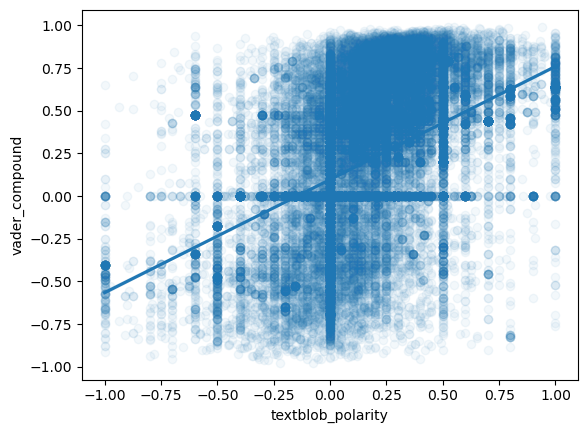

In [48]:
import seaborn as sns

sns.regplot(data = tweet_scores, x="textblob_polarity", y = "vader_compound", scatter_kws = {"alpha":0.05})

## Additional Resources

1. [Text and Data Mining Libguide](https://guides.lib.unc.edu/tdm)